In [5]:
import torch
from torch import nn

In [6]:
def test_model_class(model_class):

    model = model_class()

    for _ in range(10):

        x1, x2, x3 = torch.rand(3)

        model.zero_grad()
        y_torch = model(x1, x2, x3)
        y_torch.backward()
        grad_torch = model.w.grad.clone()

        print(y_torch.clone().detach().numpy(), grad_torch.clone().numpy())

        model.zero_grad()
        with torch.no_grad():
            y_manual = model.your_forward_backward(x1, x2, x3)
        grad_manual = model.w.grad.clone()

        print(y_manual.numpy(), grad_manual.numpy())
        print()

        assert torch.allclose(y_manual, y_torch)
        assert torch.allclose(grad_manual, grad_torch)

    print('Tests completed successfully!')

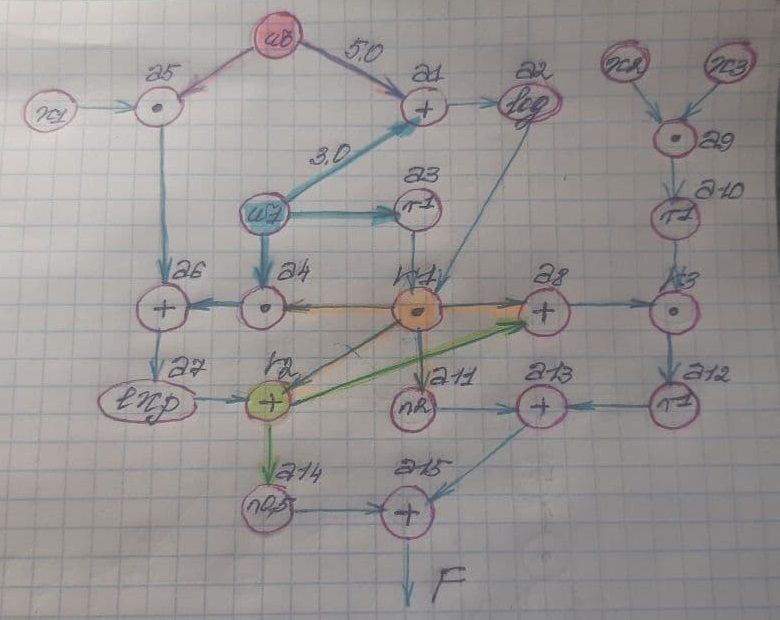

In [7]:
'''
df/da15 = 1.0
df/da14 = df/da15 * da15/da14 =                                                   1.0 * 1.0
df/da13 = df/da15 * da15/da13 =                                                   1.0 * 1.0
df/da12 = df/da13 * da13/da12 =                                                   1.0 * 1.0
df/dr3 = df/da12 * da12/dr3 = 1.0 * (-1) * r3 ** (-2) =                           - r3 ** (-2)

df/da11 = df/da13 * da13/da11 =                                                   1.0 * 1.0
df/da10 = df/dr3 * dr3/da10 =                                                     - r3 ** (-2) * a8
df/da9 = df/da10 * da10/da9 = - r3 ** (-2) * a8 * (-1) * a9 ** (-2) =             r3 ** (-2) * a8 * a9 ** (-2)
df/da8 = df/dr3 * dr3/da8 =                                                       - r3 ** (-2) * a10
df/dr2 = df/da14 * da14/dr2 + df/da8 * da8/dr2 = 
       = 1.0 * 0.5 * r2 ** (-0.5) - r3 ** (-2) * a10 * 1.0 =                      0.5  * r2 ** (-0.5) - r3 ** (-2) * a10 

df/da7 = df/dr2 * dr2/da7 =                                                       (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * 1.0         
df/da6 = df/da7 * da7/da6 =                                                       (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * torch.exp(a6)
df/da5 = df/da6 * da6/da5 =                                                       (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * torch.exp(a6) * 0.1
df/da4 = df/da6 * da6/da4 =                                                       (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * torch.exp(a6) * 0.1
df/dr1 = df/da11 * da11/dr1 + df/dr2 * dr2/dr1 + df/da8 * da8/dr1 + df/da4 * da4/dr1 = 
      = 1.0 * 2 * r1 
      + (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * 1.0 
      - r3 ** (-2) * a10 * 1.0 
      + (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * torch.exp(a6) * self.w[1] =    2 * r1 
                                                                                  + (0.5  * r2 ** (-0.5) - r3 ** (-2) * a10) * (1 + torch.exp(a6) * self.w[1])
                                                                                  - r3 ** (-2) * a10 
''';
# А дальше легко 

## Вариант, как в примере 

In [30]:
class Tatyana(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor([0.939, 0.937], dtype=torch.float32))
        
    def forward(self, x1, x2, x3):
        r1 = torch.log(self.w[1] * 3.0 + self.w[0] * 5.0) / self.w[1]
        r2 = r1 + torch.exp(self.w[1] * r1 + self.w[0] * x1)
        r3 = (r1 + r2) / (x2 * x3)
        return r1 ** 2.0 + r2 ** 0.5 + 1.0 / r3

    # implement forward and backward manually
    def your_forward_backward(self, x1, x2, x3):
        # forward
        a1 = self.w[0] * 5.0 + self.w[1] * 3.0
        a2 = torch.log(a1)
        a3 = self.w[1] ** (-1)
        r1 = a3 * a2 

        a4 = r1 * self.w[1]
        a5 = self.w[0] * x1 
        a6 = a4 + a5
        del a4, a5
        a7 = torch.exp(a6)
        r2 = a7 + r1 
        del a7

        a8 = r1 + r2 
        a9 = x2 * x3
        a10 = a9 ** (-1)
        del a9
        r3 = a8 * a10
        del a8
        a11 = r1 ** 2
        a12 = r3 ** (-1)
        a13 = a11 + a12
        del a11, a12
        a14 = r2 ** 0.5
        a15 = a13 + a14 
        del a13, a14
        # f = a15
        
        # backward
        da15 = 1.0
        da14 = da15 * 1.0
        da13 = da15 * 1.0
        del da15
        da12 = da13 * 1.0 
        dr3 = da12 * (-1) * r3 ** (-2)
        del da12, r3

        da11 = da13 * 1.0
        del da13
        # da10 = dr3 * a8                 # Зачем нам распространять градиент на константы? 
                                          # Правильно, незачем. 
        # del a8
        # da9 = da10 * (-1) * a9 ** (-2) 
        # del a9
        da8 = dr3 * a10
        del dr3, a10
        dr2 = da14 * 0.5 * r2 ** (-0.5)  + da8 * 1.0
        del da14, r2

        da7 = dr2 * 1.0
        da6 = da7 * torch.exp(a6)
        del da7, a6
        da5 = da6 * 1.0
        da4 = da6 * 1.0
        del da6
        dr1 = da11 * 2 * r1 + dr2 * 1.0  + da8 * 1.0 + da4 * self.w[1]
        del da11, dr2,  da8       

        da3 = dr1 * a2
        del a2
        da2 = dr1 * a3 
        del dr1, a3
        da1 = da2 / a1
        del da2, a1

        # actual weight grads
        # df/dw1 = df/da4 * da4/dw1 +  df/da3 * da3/dw1 + df/da1 * da1/dw1
        dw1 = da4 * r1 + da3 * (-1) * self.w[1] ** (-2) + da1 * 3.0
        del da4, r1, da3
        # df/dw0 = df/da5 * da5/dw0 +  df/da1 * da1/dw0 
        dw0 = da5 * x1 + da1 * 5.0
        del da5, da1
        self.w.grad = torch.stack([dw0, dw1])
        return a15

test_model_class(Tatyana)

8.527636 [ 5.1978617 -7.6205206]
8.527634 [ 5.1978607 -7.6205177]

7.9542656 [ 4.2370324 -7.7973337]
7.9542646 [ 4.2370305 -7.7973323]

8.496779 [ 5.1979184 -7.6221952]
8.4967785 [ 5.197918  -7.6221933]

8.194933 [ 4.660345  -7.7159214]
8.194931 [ 4.660345 -7.715921]

8.223634 [ 4.714389 -7.70619 ]
8.223632 [ 4.714388 -7.706189]

7.8793316 [ 4.1288443 -7.8209615]
7.8793306 [ 4.128844  -7.8209605]

7.8446794 [ 4.125884  -7.8256044]
7.844678 [ 4.125883 -7.825602]

8.041001 [ 4.427663  -7.7618856]
8.040999 [ 4.427662  -7.7618837]

8.639428 [ 5.4026346 -7.5875463]
8.639427 [ 5.402633  -7.5875454]

9.026814 [ 6.115591  -7.4805784]
9.0268135 [ 6.11559   -7.4805775]

Tests completed successfully!


In [ ]:
model = Tatyana()
x1, x2, x3 = torch.rand(3)
torch.onnx.export(
    model,
    (x1, x2, x3),
    'graph.onnx',
    opset_version=13,
    export_params=True,
    do_constant_folding=False,
    input_names=['x1', 'x2', 'x3'],
    output_names=['y'],
)